In [1]:
import os
import ML_utils
import torch as nn

path2data = "./data"
sub_folder_jpg = "hmdb51_jpg"
jpg_path = os.path.join(path2data, sub_folder_jpg)



In [2]:
#Calls get_vids to get a list of all the videos, labels, and categories in the dataset.
all_vids, all_labels, catgs = ML_utils.get_vids(jpg_path) 
len(all_vids), len(all_labels), len(catgs)

(6766, 6766, 51)

### Preprocessing
Now we have our data in jpg form, but this still isn't good enough to feed into a ML model. Here, I call get_vids to go into all the subdirectories of jpg_path(our video folder) and makes the full path between categories and jpg_path. If the item being looked at is in fact a directory and doesn't start with '.' (I had some problems with the mac OS and a file called .DS Store), we also create full paths between frames and jpg_path. Lastly, we output a list of all paths to frames and their corresponding labels (subdirectory name) 

In [3]:
#Creates a dictionary of the categories and their corresponding labels.
labels_dict = {}
ind = 0
for cat in catgs:
    if cat.startswith('.'):
        continue
    labels_dict[cat] = ind
    ind+=1
labels_dict

#Creates a reverse dictionary
index_to_label = {v: k for k, v in labels_dict.items()}

In [4]:
num_classes = 2        #Testing that methods work for the first 5 classes (may switch back if I buy GPU).
#Adds all ids and labels for the first *num_classes* classes to a list.
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids),len(unique_labels)


(233, 233)

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit


#Splits data in a stratified & shuffled way
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0) #Multiple splits

for train_indx, test_indx in sss.split(unique_ids, unique_labels):
    train_ids = [unique_ids[ind] for ind in train_indx]
    train_labels = [unique_labels[ind] for ind in train_indx]
    test_ids = [unique_ids[ind] for ind in test_indx]
    test_labels = [unique_labels[ind] for ind in test_indx]

    # Optionally print information about the split
    print(f"Train set size: {len(train_ids)}, Test set size: {len(test_ids)}")

train_ids[0][:5], train_labels[0][:5]


Train set size: 209, Test set size: 24


('./dat', 'ride_')

In [6]:
test_ids[0][:5], test_labels[0][:5]

('./dat', 'ride_')

### Feature Engineering
Here, we take our categories and turn them into a dictionary where the keys are the label names and the values are a corresponding number 0-51. I also create a reverse dictionary to help make sure that the datasets I create below work as intended.

We then set up a small block of code that lets us control the number of classes that we will use for our model later. I am not able to run this whole dataset on my computer so I tried downsizing to a smaller number of classes to see if that would help. I may end up renting a GPU for this though, tbd. I check to make sure the number of samples is still the same, then divide the data into 3 folds of training and testing data via sklearn's StratifiedShuffleSplit. I set the number of splits to be 3, 10% of data to be test data, and random_state to be 0 in order for my results to be reproducible. StratifiedShuffleSplit separates the data into different splits while maintaining prior probabilities. It also shuffles the data so the model doesn't rely on any kind of information between samples. Test sets will not necessarily be completely mutually exlusive, but they will be close(sklearn).

After this is done, we iterate over our splits and create lists of training/testing videos and labels with shape [#splits, #samples in category of split]. I then check that the first 5 elements of the first trainign split to make sure it still is working fine.

In [7]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
#Random seed for reproducibility
np.random.seed(200)
random.seed(200)
torch.manual_seed(200)

class VideoDataset(Dataset):
    #Constructor
    def __init__(self, ids, labels, transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
    #Length
    def __len__(self):
        return len(self.ids)
    #Getter
    def __getitem__(self, idx):
        #Get all the frames in the video and corresponding label
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:16]
        label = labels_dict[self.labels[idx]]
        frames = []
        #For each frame, open the image and apply the transform
        for path2img in path2imgs:
            frame = Image.open(path2img)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frame_out = []
        #Apply the same seed to all frames in the video
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frame_out.append(frame)
        if len(frame_out)>0:
            frame_out = torch.stack(frame_out) #Turns frames into tensor [num_frames, channels, height, width]
        return frame_out, label

### Preprocessing

Here, I am creating a dataset that I can use to put in my dataloader later. I set seeds to make my outputs reproducible here as well. The dataset is defined by the ids and labels I created earlier, and a set of transforms I define below. 

__len__ returns the length of the dataset. 

__getitem__ uses glob to get a list of all the jpg files in the directory (in case any aren't jpg files), and takes the first 16 frames (again all videos should be 16 frames already but just in case). We get the label for the image using the label dictionary created earlier. We then open all frames in the video using PIL and add them to a frames list. We randomly transform each frame, and add it to our output list. Once this is done, we turn the output list into a tensor of shape [num_frames, channels, height, width] and output it with the corresponding label.

In [8]:
# Two models:
model_type = "3dcnn"
#model_type = "rnn"    

if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406] #Weights for RNN pretrained on ImageNet 
    std = [0.229, 0.224, 0.225] #Weights for RNN pretrained on ImageNet
if model_type == "3dcnn":
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645] #Weights for 3D-CNN pretrained on Kinetics
    std = [0.22803, 0.22145, 0.216989]  #Weights for 3D-CNN pretrained on Kinetics

### Preprocessing

Here, I give two options for model_type, 3D-CNN, or RNN. To use either one, you can # out / leave in the model_type = "rnn" line. I chose to pretrain my models in order to take advantage of transfer learning and have them converge faster as I don't have unlimited GPU power. I learned about this at my internship over the summer and it is perfect here as this is very similar to an object classification task. I found a pytorch page that recommended the 'else' weights which were found using the Kinetics dataset. The RNN needed be downsized to 224x224 because this is the default size needed for the base model I used(ResNet18). I downsized the 3DCNN more than the RNN because its more robust in order to have comparable training times. 

In [9]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),   #Resize to desired size
            transforms.RandomHorizontalFlip(p=0.5),  #Flip image half the time, makes model more robust
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),   #Translate 10% in any direction
            transforms.ToTensor(),  #Turns to tensor
            transforms.Normalize(mean, std), #Normalize
            ])     


### Feature Extraction

These are the transformations I mentioned earlier. These transformations were recommended by KeyLabs.ai. I didn't want to get too crazy so I stuck with geometric transformations and didn't mess with rotation. Overall, this downsizes our image depending on the method chosen, has a 50% chance to flip the image, translates it up to 10% in any direction, converts the image from the PIL image it was opened as to a tensor, then normalizes the color channels by their corresponding mean and std.

In [10]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer) #Create dataset

### Preprocessing

Creates training dataset using splits and transforms from above. Flattens training data beforehand so Dataset can work as intended.

In [11]:
imgs, label = train_ds[11] #This is the correct dimensions for a video input which is good. 
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 112, 112]), 1, tensor(-1.8952), tensor(2.2022))

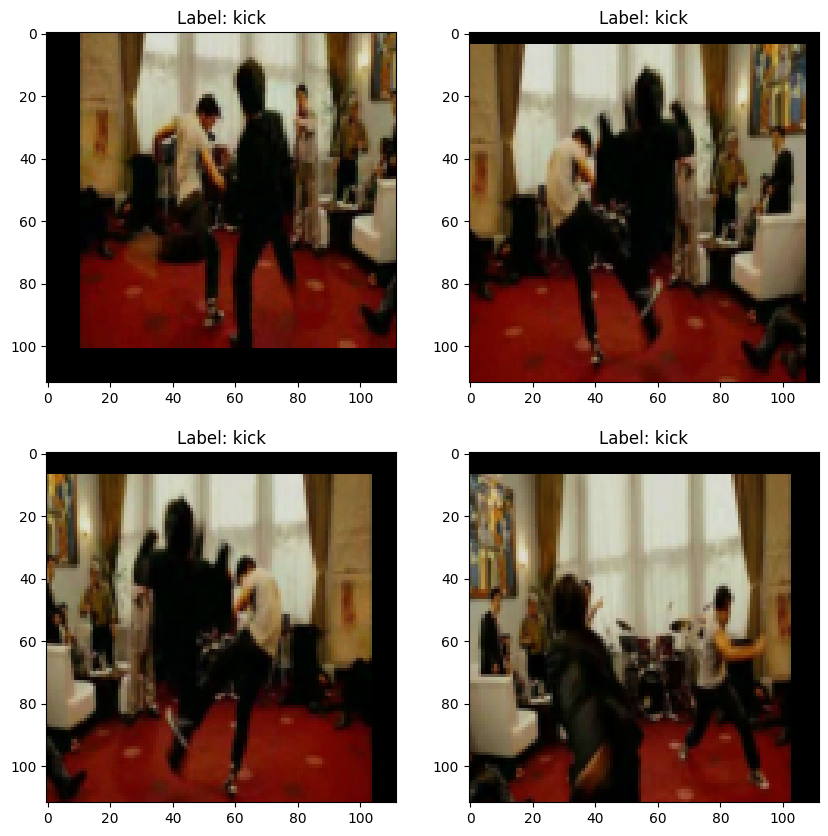

In [12]:
import matplotlib.pylab as plt

#Visualize the first 4 frames of a train video
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(ML_utils.denormalize(img, mean, std))
    plt.title(f"Label: {index_to_label[label]}")

In [13]:
#Simpler version of training, don't need to worry about training 
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 

In [14]:
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer) #Create dataset
print(len(test_ds))

24


In [15]:
#Test the dataset
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 112, 112]), 1, tensor(-1.7404), tensor(2.3970))

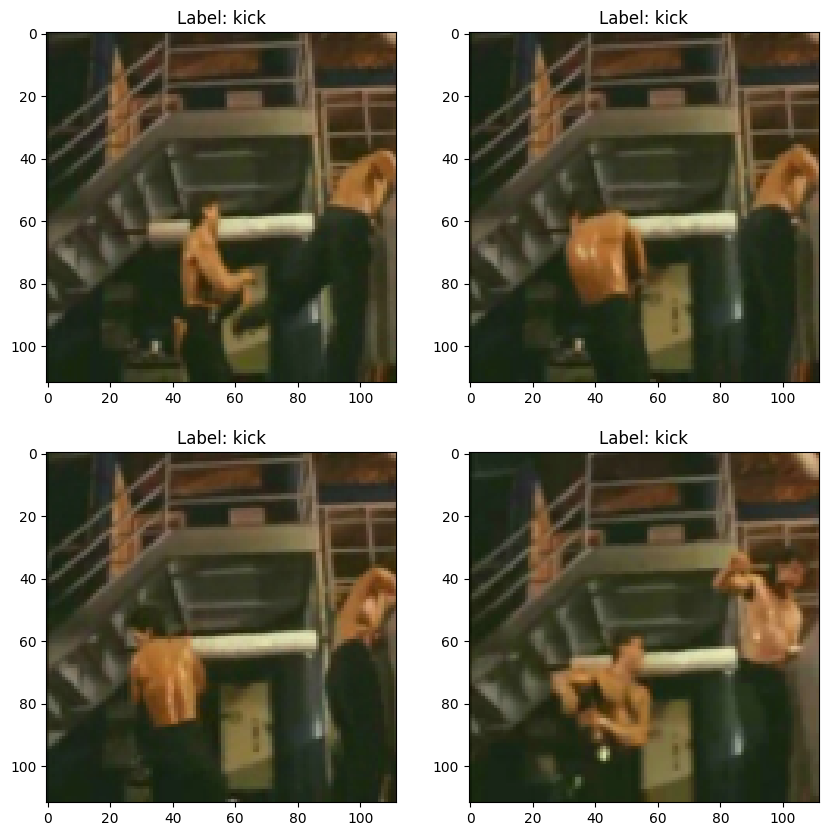

In [16]:
#Visualize the first 4 frames of a test video
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(ML_utils.denormalize(img, mean, std))
    plt.title(f"Label: {index_to_label[label]}")

### Preprocessing

Above, I spend some time making sure that our training images and labels still match. I also do a similar transformation with the test frames except I just downsize them, turn them into tensors, and normalize them (no extra transformations necessary as no learning). I then flatten the test data and put it in its own test dataset. I then make sure our testing images and labels still match.

In [17]:
#Define collate functions for the Dataloaders
def collate_fn_3DCNN(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1) #Turns into tensor of size (batch_size, height, channels, width) for CNN
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 1
#Load data into Dataloader
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)  
if model_type == "3dcnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                          shuffle=True, collate_fn= collate_fn_3DCNN)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                         shuffle=False, collate_fn= collate_fn_3DCNN)

### Preprocessing

Here, I make different collate functions for the RNN and CNN. I make these to make sure our batches are going to be handled properly in our dataloader. Most of the steps are the same for both. When given a batch, which I've set to 1, we unzip the batch into images and labels. We then take all the images into a list and convert the labels into a tensor. We stack the images into a tensor of size (batch_size,channels, height, width) and the labels into a tensor of size (batch_size, 1). CNNs need a shape of (batch_size, height, channels, width) though, so we transpose the 1st and 2nd dimensions(considering batch_size to be dimension 0). We then return these tensors.

After this, we load our data into their corresponding DataLoaders, differentiated by their collate functions. We set shuffle to be true for training and false for testing. Although this isn't necessarily needed as we shuffled earlier, it doesn't hurt. 

Below, we check the dimensions of the active model's dataloader and make sure its the right size. Notice we doubled the batch size of the testing loader since its less computationally complex so the first dimension is 2 compared to 1.

In [18]:
#Test the Dataloader)
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([1, 3, 16, 112, 112]) torch.Size([1])
torch.Size([2, 3, 16, 112, 112]) torch.Size([2])


### Preprocessing
Checks that dataloader is of correct size. It is so we're good to keep going

In [19]:
#Outlines Resnet18 model with LSTM
import torch.nn as nn
class Resnet18Rnn(nn.Module):
    #Constructor
    def __init__(self, params_model):
        #Parameters
        super(Resnet18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        #Layer definitions
        baseModel = models.resnet18(pretrained=pretrained) #Gets pretrained resnet18 model
        num_features = baseModel.fc.in_features
        baseModel.fc = PassThrough()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    #Forward pass
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        i = 0
        y = self.baseModel((x[:,i]))  
        output, (hn, cn) = self.rnn(y.unsqueeze(1)) #only care about final output
        #Learns probabilities through iterating through frames in a video
        for i in range(1, ts):
            y = self.baseModel((x[:,i]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class PassThrough(nn.Module): #Remove final layer of resnet18 model so we can input into LSTM instead. 
    def __init__(self):
        super(PassThrough, self).__init__()
    def forward(self, x):
        return x    

### Method 1: RNN

There's already been some talk about the different preprocessing steps I have to do depending on the model, but here is the bulk of my RNN code. Here, I initialize my model with a number of parameters such as #classes, dropout rate, whether my model is pretrained, the hidden size of the model, and #parameters. I also initialize the base model of ResNet which mostly consists of a combination of convolution layers, pooling layers, and residual blocks. I can go into more detail on how this works during Q&A if desired. We take the number of features from this base model(512) as well. 

ResNet is good at handling 2D data, but we need to add another model in order for it to handle temporal data. To do this, we remove the final fully connected layer of the model through the use of the PassThrough class and instead feed directly to an LSTM (after a dropout layer). This LSTM handles temporal data by keeping a hidden state that holds information about its past states. The RNN features from earlier are inputted here, and I chose to use only 1 layer with a hidden size of 128 to keep the model relatively lightweight while still hopefully being able to get temporal data. An article I read from medium recommend a size of 128 for image classification, so that's what I used. Finally, I have a linear layer to give class probabilities.

forward: Iterates first frame through ResNet model and LSTM, outputting the predicted class, the hidden state of the LSTM, and the cell state of the LSTM. We then iterate through the rest of the frames until we reach the end. We get a final output from the LSTM which we then do dropout on for regularization. Finally, we run the output through a linear layer to get the class probabilities which we return. We have to unsqueeze the output y because we need the input to be of the form (batch_size, seq_len, input_size). Since we have are only iterating over one from at a time, we set seq_len to be 1. 

### Method 2: 3D-CNN

The second model I chose to use was a pretrained 3D-CNN. I pulled this model from the pytorch models directory. This model works very similarly to ResNet as it also uses mostly convolutional and pooling layers with RELU, dropout, etc. The biggest difference is that while ResNet works in two dimensions, this model works in 3D. In that sense, instead of going frame by frame to get an output, it takes the entire video as an input where the third dimension is time. Similar to before, we set the last layer of this model to be a linear layer that connects the in_features (values right before the final layer) to the a number of nodes equal to the number of class(51 in our case). In this way, our output will be an array of the probabilities of each class. As mentioned before, if you'd like me to go into more detail during Q/A I can.

In [20]:
from torchvision import models
from torch import nn
#Defines paramters based on model type
if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 128,}
    model = Resnet18Rnn(params_model)        
if model_type == "3dcnn":
    model = models.video.r3d_18(pretrained=True, progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

/Users/owenwitt/Desktop/Guided Research/Guided Research Code/First Neural Network/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/owenwitt/Desktop/Guided Research/Guided Research Code/First Neural Network/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Preproccesing
Denotes the model and its corrresponding parameters depending on the model_type variable mentioned above.

In [21]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(1, 16, 3, h, w)
    else:
        x = torch.zeros(1, 3, 16, h, w) #CNN needs swapped dimensions
    y= model(x)
    print(y.shape)

torch.Size([1, 2])


### Model Checking

Checks that output is of the correct size.

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Good practice
model = model.to(device)
#model

In [23]:
path2weights = "./models/weights"
torch.save(model.state_dict(), path2weights + "_" + model_type + ".pt")

### Model Weights

Saves starting weights of model. Will be overwritten below. 

In [24]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

#Defines loss function, optimizer, and learning rate scheduler
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)
#Defines parameters for training
params_train={
    "num_epochs": 20,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": False,  #Set to True to check the forward pass and the loss
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = ML_utils.train_val(model,params_train)

/Users/owenwitt/Desktop/Guided Research/Guided Research Code/First Neural Network/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0/19, current lr=3e-05


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Copied best model weights!
train loss: 0.658119, dev loss: 0.629253, accuracy: 79.17
----------
Epoch 1/19, current lr=3e-05


 20%|█▉        | 41/209 [00:39<02:43,  1.03it/s]


KeyboardInterrupt: 

### Running Models

Start of by setting loss function to be Cross Entropy Loss, our optimizer to be the Adam optimizer, and our learning rate scheduler to be ReduceLROnPlateau. I chose cross entropy loss as it grades harder based on the 'wrongness' of the model, and is a staple of deep learning models and image/video classification. I chose the Adam Optimizer because of its commonplace in these tasks as well and is generally good at a lot of tasks. I am using the ReduceLROnPlateau learning rate scheduler becasue I'm fine tuning pre-trained models. It's common for the validation to plateau when fine tuning, so I've added ReduceLROnPlateau to reduce the learning rate when that occurs. This will allow our models to converge to the best possible answer as they won't endlessly oscillate due to overshooting from a too high learning rate. Also lets me be more lenient in what I choose as my learning rate.

We then feed the parameters, our training and testing datasets, and the number of epochs into our model (among other things). I chose the nuber of epochs to be 50 for both models as according to various sources I would need anywhere from a few dozen to a few hundred epochs. As I don't have the time to do a few hundred, I chose the lesser end. 

Our model is ran through the train_val function. This is a relatively straightforward learning/validation cycle.

In [ ]:
ML_utils.plot_loss(loss_hist, metric_hist)